In [3]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
#from scipy.integrate import odeint
#import numpy as np
import pandas as pd
#from sklearn.metrics import r2_score
from tensorflow import keras
#from skopt.space import Space
#from eml.net.reader import keras_reader

# Load pre-trained models
fsm_early = keras.models.load_model('fsm_early')
fsm_late = keras.models.load_model('fsm_late')

# Generate dataset
nitems, nsamples = 10, 500
data = util.generate_market_dataset(nsamples, nitems, seed=2, noise=.02)
data_tr, data_ts = util.train_test_split(data, test_size=0.3, seed=42)
tr_in, tr_out = data_tr.index.values, data_tr.values
ts_in, ts_out = data_ts.index.values, data_ts.values

# Define the optimization problem
prb = util.generate_market_problem(nitems=nitems, rel_req=0.5, seed=42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Decision-Focused Learning

Where we discover that things ain't that easy

## The Main Challenge

**We are now ready to tackled decision-focused learning**

Let's start from the "holy grail" problem:

$$
\text{argmin}_{\omega} \left\{ \sum_{i=1}^m c(z^*(y_i), \hat{y}_i) \mid y = f(\hat{x}, \omega) \right\}
$$

Unfortunately, the $\text{argmin}$ used to define $z^*(y_i)$ is _non-differentiable_

* A small change in the prediction vector $y_i$
* ...May cause a large/discrete change in the optimal solution $z_i$

This is certainly the case for our example problem

> **How are we going to deal with this?**

## Sometimes...

<center><img src="assets/sh.jpg" width="65%"/></center>

> **Sub-grandient!**

## Towards a Solution

**A possible solution consists in using a _surrogate loss_**

For the $i$-th example:

* Since $z^*(\hat{y}_i)$ is the optimal solution for the true costs $\hat{y}_i$
* We expect that to _remain optimal_ for a good vector $y_i$ of predicted costs

**In practice, we could train the model to minimize the _regret_:**

$$
r_i^*(y_i) = c(z^*(\hat{y}_i), y_i) - c(z^*(y_i), y_i)
$$

* This quantity is always non-negative (since $z^*(y_i)$ is a cost minimizer w.r.t. $y_i$)
* It becomes 0 when the two solutions match
* It contains a naturally differentiable term, i.e. $y_i = f(\hat{x}_i)$

**...But unfortunately also a _non-differentiable_ term, i.e. $z^*(y_i)$**

## Towards a Solution

**We can view the regret computation as a maximization problem**

$$
r_i^*(y_i) = \max_{z \in F(y_i)} r_i(z, y_i) \\
\text{with: } r_i(z, y_i) = c(z^*(\hat{y}_i), y_i) - c(z, y_i)
$$

This enables casting the "holy grail" problem as _bi-level optimization_:

$$
\text{argmin}_{\omega} \left\{ \sum_{i=1}^m \max_{z \in F(y_i)} r_i(z, y_i) \mid y = f(\hat{x}, \omega) \right\}
$$

...And for bi-level optimization problem we can rely on _two great results_

* That are remarkably easy to use
* ...But have a mildly complicated proof and require some assumptions

## Bi-level Optimization and Subgradient

**First of all, let simplify the problem by assuming a _fixed feasible set_**

$$
F(y_i) = F
$$

* This assumption limits the approach applicability
* ...But it remains useful on many real world problems

**Then, let's focus on a single example**

We have that, for a generic prediction vector $y$:

$$
\max_{z \in F} r_i(z, y) \geq r_i(z_i, y)
$$

* Where $z_i$ is a compact notation for $z^*(y_i)$
* The result stands since $z_i$ is not necessarily optimal w.r.t. $y$

## Bi-level Optimization and Subgradient

**If $r_i(z, y)$ is _differentiable_, we can expand it via Taylor's theorem**

We will use as a reference the current prediction vector $y_i$:

$$
r_i(z_i, y) = r_i(z_i, y_i) + \nabla_y r_i(z_i, y_i) (y - y_i) + o(\|y - y_i\|)
$$

* For $y \rightarrow y_i$, the $o(\|y - y_i\|)$ term will become vanishingly small
* Therefore we will have:

$$
\max_{z \in F} r_i(z, y) \geq r_i(z_i, y_i) + \nabla_y r_i(z_i, y_i) (y - y_i)
$$

Which can be rewritten as:

$$
\max_{z \in F} r_i(z, y) - \max_{z \in F} r_i(z, y_i) \geq \nabla_y r_i(z_i, y_i) (y - y_i)
$$

## Bi-level Optimization and Subgradient

**Let's look again at the last inequality**

$$
\max_{z \in F} r_i(z, y) - \max_{z \in F} r_i(z, y_i) \geq \nabla_y r_i(z_i, y_i) (y - y_i)
$$

* We are saying that the regret _difference_ locally admits a _linear under approximation_
* ...Which uses $\nabla_y r_i(z_i, y_i)$ as a coefficient vector

**Formally, this means that $\nabla_y r_i(z_i, y_i)$ is a local _subgradient_**

...But what is $\nabla_y r_i(z_i, y_i)$ exactly?

* It's what you get by taking the regret expression $r(z, y)$
* Plugging in $z_i$ for $z$
* Differentiating over $y$
* ...And finally plugging in $y_i$ for $y$

## Bi-level Optimization and Pseudo-convexity

**If $r_i(z, y)$ is _linear in $y$_, then:**

* The Taylor expansion becomes exact:
* ...And our main inequality holds _everywhere_:

$$
\max_{z \in F} r_i(z, y) - \max_{z \in F} r_i(z, y_i) \geq \nabla_y r_i(z_i, y_i) (y - y_i)
$$

**This means our inner optimization function is _pseudo-convex_**

A pseudo-convex function behaves as convex for the purpose of optimization


* I.e. If we could freely control $y_i$...
* ...Then we could _optimally solve_ $\min_{y_i} \max_{z \in F} r_i(z, y_i)$
* ...Via simple _sub-gradient descent_

**Both result hold for bi-level optimization in general!**

## Beyond Decision Focused Learning

**These are _general results_**

Given a bi-level optimization in the form:

$$
\min_{y \in Y} \max_{x \in X} f(x, y)
$$

With:

$$
x^*(y) = \text{argmin}_{x \in X} f(x, y)
$$

Then:

* If $f$ is differentiable, $\nabla_y f(x^*(y), y)$ is a valid subgradient w.r.t. $y$
* If $f$ is linear, $f^*(y) = \max_{x \in X} f(x, y)$ is pseudo-convex

## An Example on Our Market Problem

**Let's use our market problem, for the $i$-th example**

$$
\text{argmin}_z \{ y_i^T z \mid \|z\|_1 \geq r, z \in \{0, 1\}^n \}
$$

* The feasible space does not depend on the predicted costs, hence $F(y_i) = F$
* The regret expression is $r_i^*(z, y) = y^T z_i^*(\hat{y}_i) - y^T z$
* ...Which is differentiable and linear

**Therefore, we can get a valid subgradient:**

* First we compute the optimal solution $z_i$ ("in the forward pass")
* Then we compute $\nabla_{y} (y^T z_i^*(\hat{y}_i) - y^T z_i) = z_i^*(\hat{y}_i) - z_i$
* Since there is dependence on $y$, _our subgradient is $z_i^*(\hat{y}_i) - z_i$_

...I.e. just the difference between optima w.r.t. the true and the predicted costs 

## Almost There...

**Let's recap our plan**

* When we evaluate our ML model, we need to solve the market problem
* ...So as to compute $z^*(y_i)$ for each example (in the mini-batch)
* Then we compute the loss:

$$
L_{REG}(y, \hat{y}) = \sum_{i = 1}^m y_i^T (z^*(\hat{y}_i) - z^*(y_i))
$$

Finally we can use automatic differentiation (as usual) to get the subgradient

> **Except that with a linear cost this plan has a fatal flow**

## There, Finally!

**The problem is that our loss admits a trivial solution**

$$
L_{REG}(y, \hat{y}) = \sum_{i = 1}^m y_i^T (z^*(\hat{y}_i) - z^*(y_i))
$$

* All regret terms are _non-negative_ by definition
* ...And it's _easy to make them null_ by just predicting $y_i = 0$ for all examples

**A [possible fix](https://people.cs.kuleuven.be/~tias.guns/files/ijcai21_nce_solpool.pdf) consists in using this modified function**

$$
L_{NCE}(y, \hat{y}) = \sum_{i = 1}^m y_i^T (z^*(\hat{y}_i) - z^*(y_i)) + \hat{y}_i^T (z^*(y_i) - z^*(\hat{y}_i))
$$

* This is another surrogate loss (ready for subgradient computation)

## There, Finally!

**Let's examine the modified loss**

$$
L_{NCE}(y, \hat{y}) = \sum_{i = 1}^m y_i^T (z^*(\hat{y}_i) - z^*(y_i)) + \hat{y}_i^T (z^*(y_i) - z^*(\hat{y}_i))
$$

* The term $y_i^T (z^*(\hat{y}_i) - z^*(y_i))$ is the regret w.r.t. the predicted costs $y_i$
* The term $\hat{y}_i^T (z^*(y_i) - z^*(\hat{y}_i))$ is the regret w.r.t. the true costs $\hat{y}_i$
* Both terms are guaranteed non-negative and therefore $L_{NCE}(y, \hat{y}) \geq 0$

**We wish _both regrets to be small_ (hence the loss is valid)**

* We did not use $\hat{y}_i^T (z^*(y_i) - z^*(\hat{y}_i))$ before...
* ...Because it lack a naturally differentiable term

The corresponding subgradient would not lead to back-propagation

## There, Finally!

**It is convenient to rewrite the loss as:**

$$
L_{NCE}(y, \hat{y}) = \sum_{i = 1}^m (y_i - \hat{y}_i)^T (z^*(\hat{y}_i) - z^*(y_i))
$$

This clarifies that the loss can be minimized in two ways:

* Either by making the two _solutions_ as similar as possible, i.e. $z^*(\hat{y}_i) \simeq z^*(y_i)$
* ...Or by making the two _costs_ as similar as possible, i.e. $y_i \simeq \hat{y}_i$

**Importantly, $y_i = 0, \forall i = 1..m$ is _no longer a minimizer_**

* There are other viable surrogate losses (e.g. $SPO+$ from [this paper](https://arxiv.org/abs/1710.08005))
* ...But we will limit our analysis to this one

# A Decision Focused Learning Implementation

For those who, like me, understand code better

## A Decision Focused Learning Implementation

**An implementation of the method is available in the `util` module**

The code relies (again) on subclassing the `keras.Model` class

```python
class DFLModel(keras.Model):
    def __init__(self, prb, ..., **params):
        super(DFLModel, self).__init__(**params)
        self.prb = prb
        ...
```

At model construction time, we need to _specify the optimization problem_

```python
nnin = keras.Input(input_size)
nnout = nnin
for h in hidden:
    nnout = layers.Dense(h, activation='relu')(nnout)
nnout = layers.Dense(output_size, activation=output_activation)(nnout)
model = DFLModel(problem, inputs=nnin, outputs=nnout, ...)
```

## A Decision Focused Learning Implementation

**The `fit` function was overloaded**

* We compute all the optimal solutions w.r.t. the true costs, i.e. $z^*(\hat{y}_i)$
* Then we calling the usual `fit` function

```python
def fit(self, X, y, **kwargs):
    # Precompute all solutions for the true costs
    self.sol_store = []
    for c in y:
        sol, closed = self.prb.solve(c, tlim=self.tlim)
        self.sol_store.append(sol)
    self.sol_store = np.array(self.sol_store)
    # Call the normal fit method
    return super(DFLModel, self).fit(X, y, **kwargs)
```

## A Decision Focused Learning Implementation

**In the `train_step` method, we compute the surrogate loss**

```python
    def train_step(self, data):
        x, costs_true = data
        ...
        with tf.GradientTape() as tape:
            costs = self(x, training=True) # obtain predictions
            sols, tsols = [], []
            for c, tc in zip(costs.numpy(), costs_true.numpy()):
                sol, closed = prb.solve(c, ...) # Best w.r.t. predictions
                sols.append(sol)
                tsol = self._find_best(tc) # Best w.r.t. true costs
                tsols.append(tsol)
            sols, tsols = np.array(sols), np.array(tsols)
            cdiff = costs - costs_true # cost difference
            sdiff = tsols - sols # solution difference
            loss = tf.reduce_mean(tf.reduce_sum(cdiff * sdiff, axis=1))
        ...
```

## Early Training

**Let's train our decision-focused model for a few epochs**

In [4]:
dfm_early = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[], name='dfm', output_activation='linear')
%time history = util.train_dfo_model(dfm_early, tr_in, tr_out, epochs=30, verbose=1, validation_split=0)

Epoch 1/30
11/11 [==============================] - 1s 65ms/step - loss: 2.0735
Epoch 2/30
11/11 [==============================] - 1s 68ms/step - loss: 2.0181
Epoch 3/30
11/11 [==============================] - 1s 67ms/step - loss: 1.9616
Epoch 4/30
11/11 [==============================] - 1s 70ms/step - loss: 1.9063
Epoch 5/30
11/11 [==============================] - 1s 74ms/step - loss: 1.8487
Epoch 6/30
11/11 [==============================] - 1s 77ms/step - loss: 1.7855
Epoch 7/30
11/11 [==============================] - 1s 82ms/step - loss: 1.7207
Epoch 8/30
11/11 [==============================] - 1s 90ms/step - loss: 1.6423
Epoch 9/30
11/11 [==============================] - 1s 92ms/step - loss: 1.5737
Epoch 10/30
11/11 [==============================] - 1s 97ms/step - loss: 1.5077
Epoch 11/30
11/11 [==============================] - 1s 102ms/step - loss: 1.4546
Epoch 12/30
11/11 [==============================] - 1s 105ms/step - loss: 1.3694
Epoch 13/30
11/11 [================

## What We Loose

**It works, but there are some issues**

We will highlight them now and address one of them later

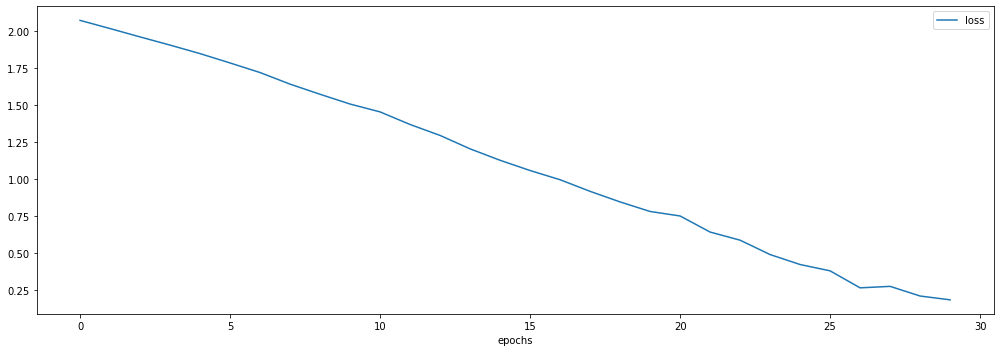

Model loss: 0.1838 (training)


In [5]:
util.plot_training_history(history, figsize=figsize)

* The loss curve is less smooth (since we are using a _sub_-gradient)
* The training time is much longer (since we need to solve optimization problems)

## What We Loose

**We also loose _a lot_ in terms of accuracy**

These are the results for our previous "early" training model

In [6]:
r2, mae, rmse = util.get_ml_metrics(fsm_early, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(fsm_early, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: -1.39, MAE: 0.3, RMSE: 0.41 (training)
R2: -1.46, MAE: 0.3, RMSE: 0.41 (test)


...And these are the results for the decision-focused model

In [7]:
r2, mae, rmse = util.get_ml_metrics(dfm_early, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(dfm_early, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: -6.45, MAE: 0.62, RMSE: 0.70 (training)
R2: -6.64, MAE: 0.63, RMSE: 0.70 (test)


## What We Gain

**But in terms of regret, we are doing much better**

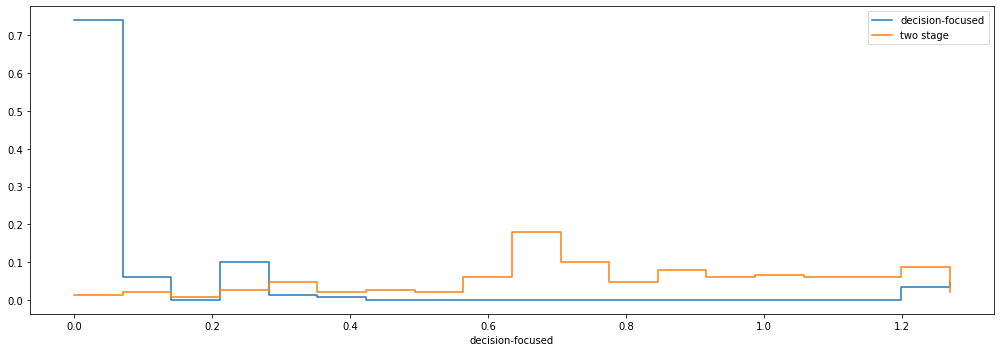

Mean: 0.142 (decision-focused), 0.785 (two stage)


In [8]:
r_ts_fsm_early = util.compute_regret(prb, fsm_early, ts_in, ts_out)
r_ts_dfm_early = util.compute_regret(prb, dfm_early, ts_in, ts_out)
util.plot_histogram(r_ts_dfm_early, figsize=figsize, label='decision-focused', data2=r_ts_fsm_early, label2='two stage', print_mean=True)

## Speeding Up the Process

**Training speed is a major bottleneck for decision-focused learning**

One possibility is to [use a relaxation](https://arxiv.org/pdf/2010.13943) that is easier to solve

* For a MILP, this would be the LP relaxation
* In general, given a relaxed feasible space $\tilde{F}$, we compute $z^*(y_i)$ as:

$$
z^*(y_i) = \text{argmin}_{z \in \tilde{F}} c(z, y_i)
$$


Another possibility consists in [keeping a solution cache](https://people.cs.kuleuven.be/~tias.guns/files/ijcai21_nce_solpool.pdf)

* We store all computed solutions in a set $S$
* Then we compute $z^*(y_i)$ via a simple enumeration step:

$$
z^*(y_i) = \text{argmin}_{z \in S} c(z, y_i)
$$

* Occasionaly, we may compute a new solution and update the cache

## Speeding Up the Process

**For MILPs, the two approaches have a nice interpretation**

<center class="smalltext">
<img src="assets/outer_inner.png" width=450px/>
Image from <a href="https://people.cs.kuleuven.be/~tias.guns/files/ijcai21_nce_solpool.pdf"> this paper</a>
</center>

Given the true feasible space (discrete points in the polytope in the figure)

* The relaxation leads to an _outer approximation_ (green), hence a lower bound
* The cache provides an _inner approximation_ (blue), hence an upper bound

## Implementing Solution Caching

**A solution caching mechanism is implemented in our code**

The computation of $z^*(y_i)$ is triggered with a _controllable probability_

```python
def train_step(self, data):
    ...
    with tf.GradientTape() as tape:
        ...
        for c, tc in zip(costs.numpy(), costs_true.numpy()):
            if np.random.rand() < self.recompute_chance: # guard
                sol, closed = prb.solve(c, tlim=self.tlim) # recompute
                if self.recompute_chance < 1: # update cache
                    if not (self.sol_store == sol).all(axis=1).any():
                        self.sol_store = np.vstack((self.sol_store, sol))
            else:
                sol = self._find_best(c) # look up in the cache
            ...
        ...
```

## Training With Solution Caching

**Let's train the model with a solution cache and 5% recomputation chance**

CPU times: user 20.3 s, sys: 1.03 s, total: 21.3 s
Wall time: 20.9 s


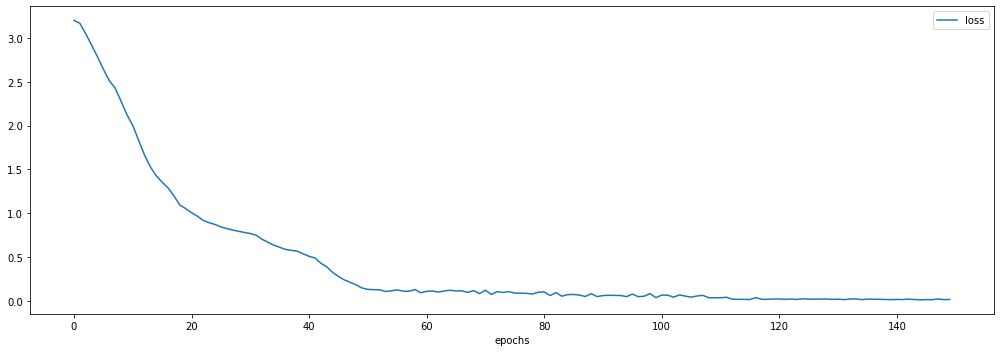

Model loss: 0.0176 (training)


In [9]:
dfm_late = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, recompute_chance=0.05, hidden=[], name='dfm_cache', output_activation='linear')
%time history = util.train_dfo_model(dfm_late, tr_in, tr_out, epochs=150, verbose=0, validation_split=0)
util.plot_training_history(history, figsize=figsize)

## Accuracy Comparison

**Since we manage to train the model to (approximate) convergence**

...It makes sense to compare with the "late" linear regression approach

In [10]:
r2, mae, rmse = util.get_ml_metrics(fsm_late, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(fsm_late, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: 0.79, MAE: 0.097, RMSE: 0.12 (training)
R2: 0.78, MAE: 0.1, RMSE: 0.12 (test)


In terms of accuracy we are doing still quite poorly

In [11]:
r2, mae, rmse = util.get_ml_metrics(dfm_late, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(dfm_late, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: -5.70, MAE: 0.61, RMSE: 0.69 (training)
R2: -5.87, MAE: 0.62, RMSE: 0.69 (test)


## Regret Comparison

**Both approaches work well, but we beat LR by a factor of at least 2**

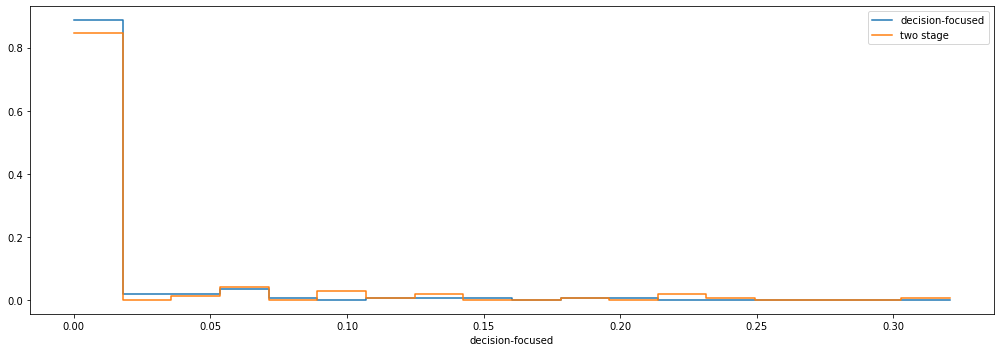

Mean: 0.009 (decision-focused), 0.020 (two stage)


In [12]:
r_ts_fsm_late = util.compute_regret(prb, fsm_late, ts_in, ts_out)
r_ts_dfm_late = util.compute_regret(prb, dfm_late, ts_in, ts_out)
util.plot_histogram(r_ts_dfm_late, figsize=figsize, label='decision-focused', data2=r_ts_fsm_late, label2='two stage', print_mean=True)

## A Deeper Look at the Predictions

**It's interesting to the check the predictions for the "late" LR model**

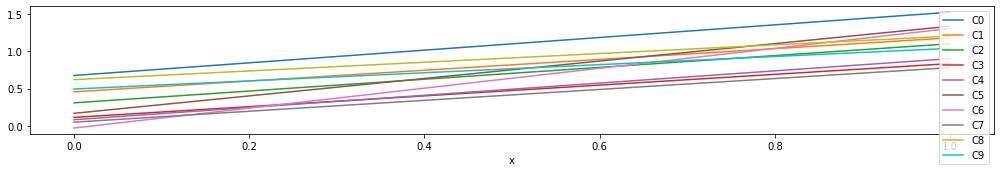

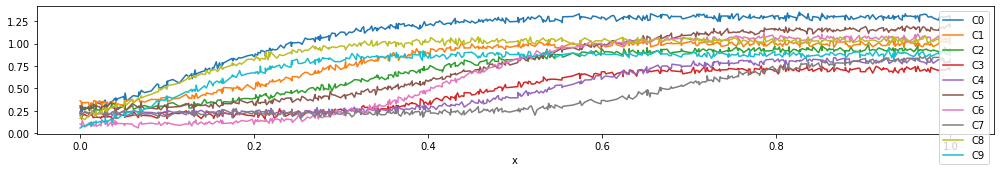

In [13]:
fsm_late_pred = pd.DataFrame(index=data.index, columns=data.columns, data=fsm_late.predict(data.index.to_numpy()))
util.plot_df_cols(fsm_late_pred, figsize=(figsize[0], 0.5*figsize[1]))
util.plot_df_cols(data, figsize=(figsize[0], 0.5*figsize[1]))

## A Deeper Look at the Predictions

**It's interesting to the check the predictions for the "late" LR model**

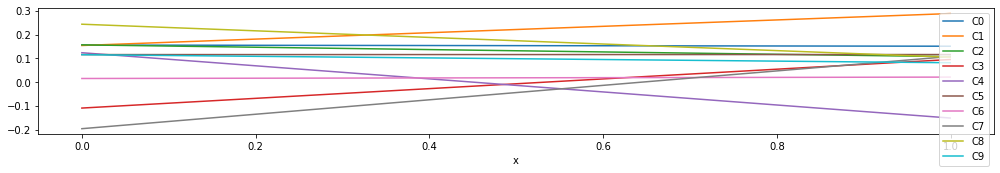

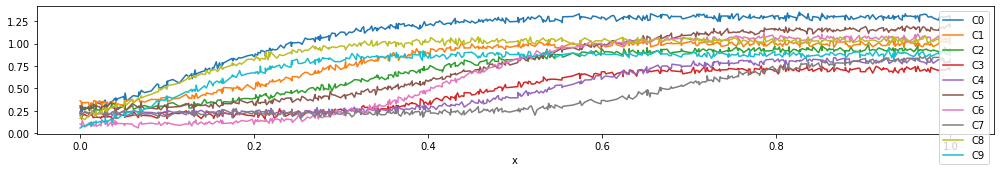

In [14]:
dfm_late_pred = pd.DataFrame(index=data.index, columns=data.columns, data=dfm_late.predict(data.index.to_numpy()))
util.plot_df_cols(dfm_late_pred, figsize=(figsize[0], 0.5*figsize[1]))
util.plot_df_cols(data, figsize=(figsize[0], 0.5*figsize[1]))